# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



### <font color='blue'>**Dowloading required files**</font>

> lets download the data which have italian words along with its english trasilaton

In [1]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2020-09-17 17:30:51--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.108.196, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7468237 (7.1M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.12M  4.28MB/s    in 1.7s    

2020-09-17 17:30:53 (4.28 MB/s) - ‘ita-eng.zip’ saved [7468237/7468237]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


> lets download the glove vectors ("vectors for english words"), note that this file will have vectors with 50d, 100d and 300d, you can choose any one of them based on your computing power

__ In our assignment we will be passing english text to the decoder, so we will be using these vectors in decoder embedding layer __

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2020-08-29 17:23:15--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2020-08-29 17:23:15--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca40c7c23141e02ee0b88baa137.dl.dropboxusercontent.com/cd/0/inline/A-Zh8w3W9V509FRBs2Q6z_vIl5GAHk325hebibhDv3NCe7pjEvoG-xT_xgCzmCOenx8fE2dMHRArTYUpSihBcBOjI51uki4e2K5g35Epb2UQKxc7DmKiP140HbwpUBfvSBM/file# [following]
--2020-08-29 17:23:16--  https://uca40c7c23141e02ee0b88baa137.dl.dropboxusercontent.com/cd/0/inline/A-Zh8w3W9V509FRBs2Q6z_vIl5GAHk325hebibhDv3NCe7pjEvoG-xT_xgCzmCOenx8fE2dMHRArTYUpSihBcBOjI51uki4e

### <font color='blue'>**Loading data**</font>

> if you observe the data file, each feild was seprated by a tab '\t'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(341554, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 12.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 101.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
249673,mi servirà una stanza più grande,<start> i am going to need a bigger room,i am going to need a bigger room <end>
88009,ero in biblioteca,<start> i was in the library,i was in the library <end>
180313,pesa soltanto tre chili,<start> it only weighs 3 kilograms,it only weighs 3 kilograms <end>
178790,ero così preoccupata per te,<start> i was so worried about you,i was so worried about you <end>
287320,è facile per noi parlare il giapponese,<start> it is easy for us to speak japanese,it is easy for us to speak japanese <end>
98671,lo vuoi vedere,<start> do you want to see it,do you want to see it <end>
138137,tom adesso è in australia,<start> tom is now in australia,tom is now in australia <end>
326810,io mi sento fiacco e ho un mal di testa pulsante,<start> i feel listless and have a throbbing h...,i feel listless and have a throbbing headache ...
269906,sospetto che tom abbia più di trentanni,<start> i suspect that tom is over thirty,i suspect that tom is over thirty <end>
48685,io aspetto ancora,<start> i am still waiting,i am still waiting <end>


### Teacher Forcing
<pre>
Let us consider the example data point

italian: erano occupate	
english_inp: &lt;start> they were busy	
                |     |     |    |
english_out:  they   were busy &lt;end>

if you observe the sentences, the start token is getting mapped to the first word in your english sentence, the first word is mapped to 2nd word, the 2nd word mapped to 3rd word and so on, finall the last one will is mapped to end token. i.e i the word will be mapped to i+1th word.

As we will be passing "english_inp" as an input to the decoder and the outputs(predictions) of the decoder will be compared against the "english_out" 

with this way of mapping, we can ensure that the model will predict the next word and calculate the loss accordingly.

</pre>

### Getting train and test 

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(272932, 3) (68234, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
99299,avete letto le domande frequenti,<start> have you read the faq <end>,have you read the faq <end> <end>
289723,tom provò a fare amicizia con mary,<start> tom tried to make friends with mary,tom tried to make friends with mary <end>
49371,ascoltami e basta,<start> just listen to me,just listen to me <end>
45892,io non sono un medico,<start> i am not a doctor,i am not a doctor <end>
134896,finiamo queste assurdità,<start> let is end this nonsense,let is end this nonsense <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
44183,non mi potete sollevare,<start> can not you lift me,can not you lift me <end>
268269,è sufficientemente ricco per comprare quellaut...,<start> he is rich enough to buy that car,he is rich enough to buy that car <end>
205592,poca gente parla la mia lingua,<start> few people speak my language,few people speak my language <end>
213580,tom non ammise il suo errore,<start> tom did not admit his mistake,tom did not admit his mistake <end>
12091,sono tutta orecchi,<start> i am all ears,i am all ears <end>


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


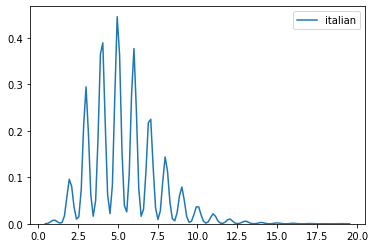

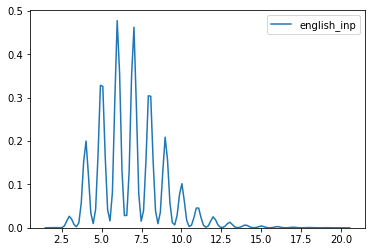

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

> Note that we are fitting the tokenizer only on train data and check the filters for english, we need to remove symbols &lt; and &gt;

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12817
26118


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10104)

In [ ]:
def grader_1(data):
    shape_value = data.shape ==(340044, 3)
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['italian'].values)
    ita_chars = tknizer.word_index.keys()
    diff_chars_ita = set(ita_chars)-set([' ', 't', 'a', 'o', 'r', 'e', 's', 'i', 'n', 'l', 'c', 'm', 'u', 'd', 'p', 'v', 'h', 'g', 'b', 'f', 'è', 'q', 'z', 'ò', 'à', 'y', 'é', 'ì', 'ù', 'k', 'w', '0', 'j', '1', '3', '2', 'x', '9', '5', '8', '4', '6', '7', 'á', 'ñ', 'ê', 'ü', 'ō', 'î', 'ö', 'ú', 'º'])
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['english_inp'].values)
    eng_chars = tknizer.word_index.keys()
    diff_chars_eng = set(eng_chars)-set(['<','>',' ', 'e', 'o', 't', 'i', 'a', 'n', 's', 'h', 'r', 'l', 'd', 'm', 'y', 'u', 'w', 'g', 'c', 'p', 'f', 'b', 'k', 'v', 'j', 'x', 'z', 'q', '0', '1', '3', '2', '9', '5', '8', '6', '4', '7'])
    unique_char_value = (len(diff_chars_eng)==0) and (len(diff_chars_ita)==0)
    return unique_char_value and shape_value

grader_1(data)

False

### Creating embeddings for english sentences

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## <font color='blue'>**Implement custom encoder decoder**</font>

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        input_embedd                           = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c
    
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = 100
        self.dec_units = dec_units
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix], trainable=False)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM")
    
    def call(self, target_sentances, state_h, state_c):
        target_embedd           = self.embedding(target_sentances)
        lstm_output, _,_        = self.lstm(target_embedd, initial_state=[state_h, state_c])
        return lstm_output

### Creating data pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
# this is the same model we have given in the other reference notebook
class MyModel(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=vocab_size_ita+1, embedding_dim=50, input_length=encoder_inputs_length, enc_units=256)
        self.decoder = Decoder(vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=decoder_inputs_length, dec_units=256)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
        
    def call(self, data):
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output                       = self.decoder(output, encoder_h, encoder_c)
        output                               = self.dense(decoder_output)
        return output

### Model training

In [ ]:
model  = MyModel(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=train_dataloader, validation_steps=valid_steps)
model.summary()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
266/266 [==============================] - 158s 595ms/step - loss: 1.8152 - val_loss: 1.6080
Epoch 2/50
266/266 [==============================] - 159s 597ms/step - loss: 1.5121 - val_loss: 1.4234
Epoch 3/50
266/266 [==============================] - 160s 601ms/step - loss: 1.3524 - val_loss: 1.2738
Epoch 4/50
266/266 [==============================] - 160s 602ms/step - loss: 1.2180 - val_loss: 1.1595
Epoch 5/50
266/266 [==============================] - 160s 602ms/step - loss: 1.1174 - val_loss: 1.0640
Epoch 6/50
266/266 [==============================] - 160s 602ms/step - loss: 1.0243 - val_loss: 0.9736
Epoch 7/50
266/266 [==============================] - 160s 603ms/step - loss: 0.9383 - val_loss: 0.8900
Epoch 8/50
266/266 [==============================] - 160s 602ms/step - loss: 0.8605 - val_loss: 0.8157
Epoch 9/50
266/266 [==============================] - 160s 602ms/step - loss: 0.7869 - val_l

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'it is ship'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

BLEU score: 0


In [ ]:
model.save_weights('model.h5')